In [ ]:
Loading the dataset and displaying a few rows :

In [1]:
import pandas as pd

data = pd.read_csv("oecd_bli_2015.csv")
data.head()

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.1,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.0,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.0,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.2,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.9,NaN,NaN


In [ ]:
Filtering the data by extracting the columns mentioned in the PDF :

In [3]:
import pandas as pd

data = pd.read_csv("oecd_bli_2015.csv", thousands=',')
data = data[data["INEQUALITY"] == "TOT"]
data = data.pivot(index="Country", columns="Indicator", values="Value")

filtered_data = data[["Years in education", "Homicide rate"]]
filtered_data = filtered_data.dropna()

pd.set_option('display.max_rows', None)

print(filtered_data)

Indicator        Years in education  Homicide rate
Country                                           
Australia                      19.4            0.8
Austria                        17.0            0.4
Belgium                        18.9            1.1
Brazil                         16.3           25.5
Canada                         17.2            1.5
Chile                          16.5            4.4
Czech Republic                 18.1            0.8
Denmark                        19.4            0.3
Estonia                        17.5            4.8
Finland                        19.7            1.4
France                         16.4            0.6
Germany                        18.2            0.5
Greece                         18.6            1.6
Hungary                        17.6            1.3
Iceland                        19.8            0.3
Ireland                        17.6            0.8
Israel                         15.8            2.3
Italy                          

In [ ]:
Creating a plot out of the Filtered Data :

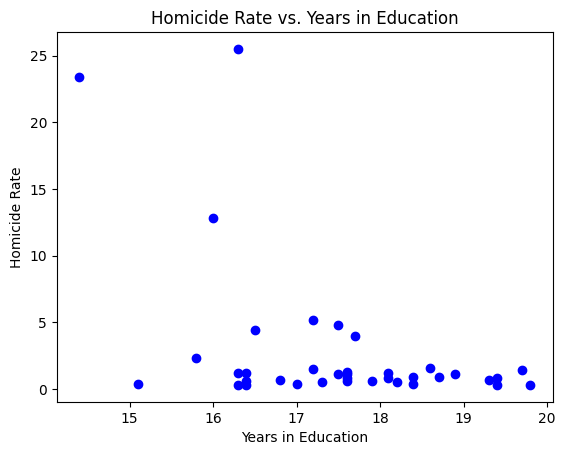

In [4]:
import matplotlib.pyplot as plt

plt.scatter(filtered_data["Years in education"], filtered_data["Homicide rate"], color='blue')
plt.xlabel("Years in Education")
plt.ylabel("Homicide Rate")
plt.title("Homicide Rate vs. Years in Education")
plt.show()

In [ ]:
Stratifying, not using StratifiedShuffleSplit, but by using train_test_split to stratify 3 times "manually"

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

data = pd.read_csv("oecd_bli_2015.csv", thousands=',')
data = data[data["INEQUALITY"] == "TOT"]  # Use only total inequality data
data = data.pivot(index="Country", columns="Indicator", values="Value")

filtered_data = data[["Years in education", "Homicide rate"]]
filtered_data = filtered_data.dropna()
# Bin the "Homicide rate" for stratification purposes
filtered_data['Homicide rate bin'] = pd.qcut(filtered_data["Homicide rate"], q=4, labels=False)

# Prepare features (X) and target (y)
X = filtered_data[["Years in education"]]
y = filtered_data["Homicide rate"]

# Repeated stratified splits
splits = []
for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=filtered_data['Homicide rate bin'], random_state=i
    )
    splits.append((X_train, X_test, y_train, y_test))
    print(f"Split {i+1}:")
    print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")

# Drop the bin
filtered_data = filtered_data.drop(columns=["Homicide rate bin"])

Split 1:
Training set size: 29, Testing set size: 8
Split 2:
Training set size: 29, Testing set size: 8
Split 3:
Training set size: 29, Testing set size: 8


In [ ]:
Removing the non-representative instances from each training dataset :

In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np

trained_models = []
cleaned_training_data = []

# Function to remove non-representative instances
def remove_outliers(model, X_train, y_train):
    y_pred = model.predict(X_train)
    
    # Calculate residuals
    residuals = y_train - y_pred
    
    # Calculate IQR for residuals
    q1 = np.percentile(residuals, 25)
    q3 = np.percentile(residuals, 75)
    iqr = q3 - q1
    
    # Define outlier threshold
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Identify non-outliers
    non_outliers = (residuals >= lower_bound) & (residuals <= upper_bound)
    
    return X_train[non_outliers], y_train[non_outliers]

for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
    print(f"Training on Split {i+1}")
    
    # Train the regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Remove non-representative instances
    X_train_cleaned, y_train_cleaned = remove_outliers(model, X_train, y_train)
    
    # Train model again
    model.fit(X_train_cleaned, y_train_cleaned)
    
    # Store the model and cleaned data
    trained_models.append(model)
    cleaned_training_data.append((X_train_cleaned, y_train_cleaned))
    
    print(f"Split {i+1} cleaned training size: {len(X_train_cleaned)}")

Training on Split 1
Split 1 cleaned training size: 26
Training on Split 2
Split 2 cleaned training size: 27
Training on Split 3
Split 3 cleaned training size: 27


In [ ]:
The contents of each split are :

In [7]:
for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
    print(f"\nSplit {i+1} - Training Data:")
    print(X_train)
    print(y_train)
    
    print(f"\nSplit {i+1} - Testing Data:")
    print(X_test)
    print(y_test)


Split 1 - Training Data:
Indicator       Years in education
Country                           
Korea                         17.5
Turkey                        16.4
Estonia                       17.5
OECD - Total                  17.7
Hungary                       17.6
United States                 17.2
Belgium                       18.9
Mexico                        14.4
Ireland                       17.6
Spain                         17.6
Denmark                       19.4
Czech Republic                18.1
Slovenia                      18.4
France                        16.4
Finland                       19.7
Canada                        17.2
Iceland                       19.8
Poland                        18.4
Switzerland                   17.3
Italy                         16.8
Chile                         16.5
Sweden                        19.3
United Kingdom                16.4
Luxembourg                    15.1
Norway                        17.9
Netherlands                  

In [ ]:
Evaluating the model for each split :

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for i, (model, (X_train_cleaned, y_train_cleaned)) in enumerate(zip(trained_models, cleaned_training_data)):
    print(f"\nEvaluating Model {i+1}")
    y_train_pred = model.predict(X_train_cleaned)
    
    # MAE, MSE, R2
    mae_train = mean_absolute_error(y_train_cleaned, y_train_pred)
    mse_train = mean_squared_error(y_train_cleaned, y_train_pred)
    r2_train = r2_score(y_train_cleaned, y_train_pred)
    
    print(f"Training Set Performance:")
    print(f"  Mean Absolute Error (MAE): {mae_train:.2f}")
    print(f"  Mean Squared Error (MSE): {mse_train:.2f}")
    print(f"  R-squared (R²): {r2_train:.2f}")


Evaluating Model 1
Training Set Performance:
  Mean Absolute Error (MAE): 1.60
  Mean Squared Error (MSE): 5.52
  R-squared (R²): 0.18

Evaluating Model 2
Training Set Performance:
  Mean Absolute Error (MAE): 1.42
  Mean Squared Error (MSE): 5.65
  R-squared (R²): 0.10

Evaluating Model 3
Training Set Performance:
  Mean Absolute Error (MAE): 1.35
  Mean Squared Error (MSE): 5.26
  R-squared (R²): 0.12


In [ ]:
Cross-validation :

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Using R2
scoring = make_scorer(r2_score)

for i, (X_train_cleaned, y_train_cleaned) in enumerate(cleaned_training_data):
    print(f"\nCross-Validation for Model {i+1}")
    
    model = LinearRegression()
    cv_scores = cross_val_score(model, X_train_cleaned, y_train_cleaned, cv=5, scoring=scoring)
    
    print(f"Cross-Validation R² Scores: {cv_scores}")
    print(f"Mean R²: {cv_scores.mean():.2f}, Standard Deviation: {cv_scores.std():.2f}")


Cross-Validation for Model 1
Cross-Validation R² Scores: [ -0.39101805 -14.312695   -15.49329738  -0.03332515   0.04721696]
Mean R²: -6.04, Standard Deviation: 7.25

Cross-Validation for Model 2
Cross-Validation R² Scores: [ -1.34105965  -1.72891388   0.10530949 -21.94498426  -0.29988146]
Mean R²: -5.04, Standard Deviation: 8.48

Cross-Validation for Model 3
Cross-Validation R² Scores: [ -0.27679509 -11.34342813 -18.86716292  -3.38047177  -0.58248735]
Mean R²: -6.89, Standard Deviation: 7.20


In [ ]:
Re-evaluation of each model :

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for i, (model, (X_train_cleaned, y_train_cleaned)) in enumerate(zip(trained_models, cleaned_training_data)):
    print(f"\nTesting Model {i+1}")
    
    # Get the corresponding test dataset
    _, X_test, _, y_test = splits[i]
    
    y_test_pred = model.predict(X_test)
    
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    print(f"Test Set Performance:")
    print(f"  Mean Absolute Error (MAE): {mae_test:.2f}")
    print(f"  Mean Squared Error (MSE): {mse_test:.2f}")
    print(f"  R-squared (R²): {r2_test:.2f}")


Testing Model 1
Test Set Performance:
  Mean Absolute Error (MAE): 1.57
  Mean Squared Error (MSE): 3.21
  R-squared (R²): -6.93

Testing Model 2
Test Set Performance:
  Mean Absolute Error (MAE): 1.22
  Mean Squared Error (MSE): 2.30
  R-squared (R²): -0.17

Testing Model 3
Test Set Performance:
  Mean Absolute Error (MAE): 1.64
  Mean Squared Error (MSE): 3.73
  R-squared (R²): -0.26
